In [2]:
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import trim_mean
#from dask.distributed import Client, LocalCluster, get_task_stream

#from itertools import product, combinations
#from cftime import DatetimeNoLeap
#from scipy.stats import ks_2samp, epps_singleton_2samp, ttest_ind, wilcoxon, mannwhitneyu
#from collections import ChainMap

In [3]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 22})
xr.set_options(keep_attrs=True,display_style='html')


In [5]:
timescale = 20
DJF_bool = '_DJFonly'
root_path = '/mnt/nas4.meop2/meop40.data.model/CMAM/0A.daily/'
root_path = '/mnt/data04/model/CMAM/0A.daily/'
cesta = f'{root_path}composites_woSSW{DJF_bool}/'

In [6]:
def open_date_file(file_path):
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    df['BeginDate'] = df.BeginDate.apply(lambda t: pd.to_datetime(t, format='%Y-%m-%d'))
    return df

In [7]:
sel_var = 'refr_index'
what = 'anomalies' # 'absolute'#
infile = f'{root_path}{sel_var }/{sel_var}_6hrPlev_CMAM_CMAM30-SD_r1i1p1_19790101-20101231_{what}.nc'
ds = xr.open_dataset(infile)
ds[sel_var] = ds[sel_var]#*24*3600.
ds = ds.resample(time = '1D').mean('time')
ds['time'] = ds.indexes['time'].to_datetimeindex()
ds['plev'] = ds['plev']/100.
ds['plev'].attrs['units'] = 'hPa'
ds

/tmp/ipykernel_1640713/4049119888.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds['time'] = ds.indexes['time'].to_datetimeindex()


<xarray.Dataset>
Dimensions:     (lat: 48, plev: 63, time: 11680, wavenumber: 3)
Coordinates:
  * time        (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2010-12-31
  * plev        (plev) float64 1e+03 925.0 850.0 800.0 ... 0.0015 0.001 0.0007
  * lat         (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * wavenumber  (wavenumber) int64 1 2 3
Data variables:
    refr_index  (time, wavenumber, plev, lat) float64 1.852e+03 ... -3.582e+03

In [10]:
def tm_mean_xr(x, dims, q = [0.1,0.9]):
    qs = x.quantile(q, dim = dims)
    return x.where((x > qs.sel(quantile = q[0])) & (x < qs.sel(quantile = q[1]))).mean(dims)

In [11]:
name_ls = ['himalayas','eastasia','westamer']
ds_ls2 = []
max_lag = 10
g_method = 'dayofyear' # 'month'

for name in name_ls:
    df_dates = open_date_file(f"accelogw_{name}_hotspot@70hPa_20dayts_indexes.csv")
    
    ds_ls = []
    for il, lag in enumerate(range(-max_lag,max_lag+1)):
        #print(lag)
        dates = df_dates.set_index('BeginDate')

        dates = dates.index + pd.Timedelta(str(lag)+' days')
        #filter lags withi 29th February
        #dates = dates[dates.apply(lambda x: not (x.day in [29] and x.month in [2]))]
        dates = dates[~((dates.month == 2) & (dates.day == 29))]
        #filter dates shited to year out of range
        #dates = dates[dates.apply(lambda x: not (x.year in [1978,2011]))]
        dates =  dates[(dates.year != 2011) & (dates.year != 1978)]
        dates = dates[(dates.month == 12) | (dates.month == 1) | (dates.month == 2)]
        
        # plev = [300,200,30,10]
        ds_sel_dates = ds.sel(time = dates, \
                              plev = slice(200,70), \
                              lat = slice(35,45))#.mean(['lat','plev']) 
        temp = tm_mean_xr(ds_sel_dates, ['lat','plev'])#(trim_mean(ds_sel_dates['refr_index'].stack(points = ('lat','plev')).values, 0.1, axis=2)
        ds_ls.append(temp)#xr.DataArray(temp, dims = ['wavenumber']))
        
    temp = xr.concat(ds_ls, dim = 'lag')
    temp['lag'] = range(-max_lag, max_lag+1)
    ds_ls2.append(temp)
    
ds_all = xr.concat(ds_ls2, dim = 'what')
ds_all['what'] = name_ls
ds_all

<xarray.Dataset>
Dimensions:     (lag: 21, time: 1565, wavenumber: 3, what: 3)
Coordinates:
  * time        (time) datetime64[ns] 1979-01-06 1979-01-07 ... 2010-12-30
  * wavenumber  (wavenumber) int64 1 2 3
  * lag         (lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 -2 ... 2 3 4 5 6 7 8 9 10
  * what        (what) <U9 'himalayas' 'eastasia' 'westamer'
Data variables:
    refr_index  (what, lag, time, wavenumber) float64 -2.349 -2.349 ... -6.39

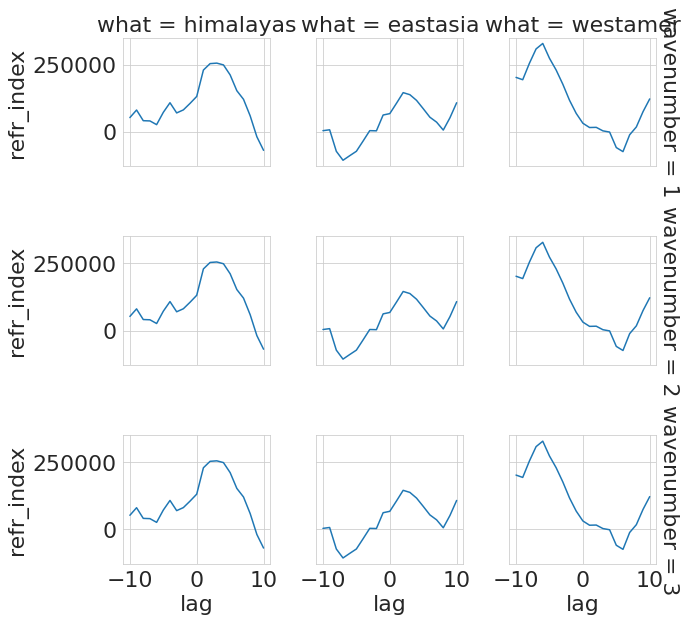

In [18]:
ds_all['refr_index'].mean('time').plot(x = 'lag', col = 'what', row = 'wavenumber')

In [13]:
df_all = ds_all.to_array().to_dataframe(name = sel_var).reset_index().drop(columns=['time'])#)
df_all.head()

,variable,what,lag,wavenumber,refr_index
0,refr_index,himalayas,-10,1,-2.349364
1,refr_index,himalayas,-10,2,-2.349364
2,refr_index,himalayas,-10,3,-2.349364
3,refr_index,himalayas,-10,1,NaN
4,refr_index,himalayas,-10,2,NaN


<AxesSubplot:xlabel='wavenumber', ylabel='refr_index'>

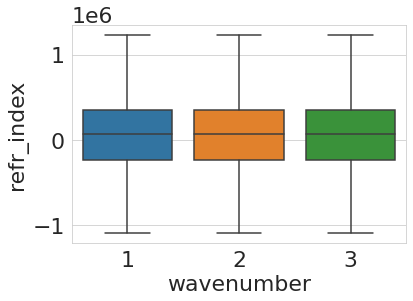

In [19]:
sns.boxplot(y = 'refr_index', x = 'wavenumber', data = df_all, showfliers = False)

<AxesSubplot:xlabel='wavenumber', ylabel='refr_index'>

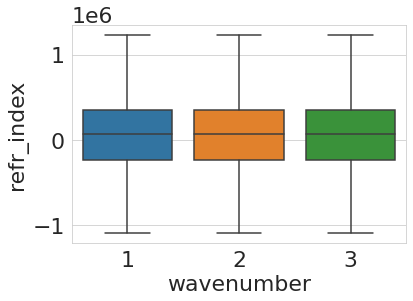

In [20]:
sns.boxplot(y = 'refr_index', x = 'wavenumber', data = df_all, showfliers = False)

<AxesSubplot:ylabel='Frequency'>

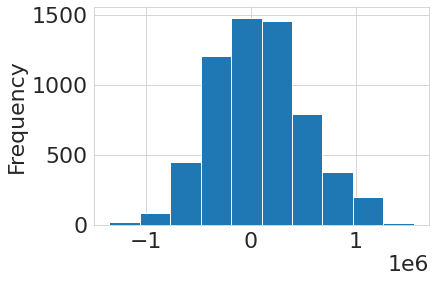

In [21]:
df_all['refr_index'].plot.hist()
#plt.ylim(0,100000)

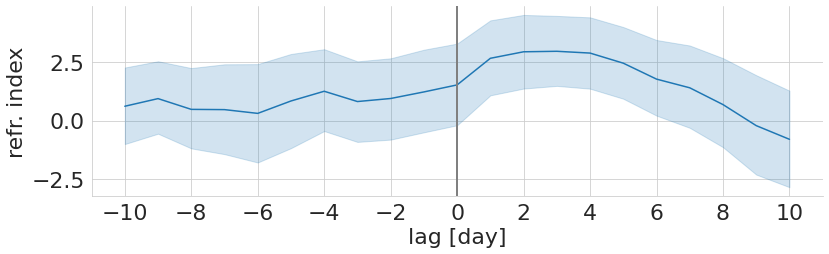

In [16]:
sel_what = 'himalayas'
threshold_dict = dict(aspect_ratio = 2.3, 
                      centroid_latitude = 72,
                      uref_ratio = 0.4,
                      kurtosis = 1.7,
                      objective_area = None)
                      
mask = (df_all['what'] == sel_what) & (df_all['wavenumber'] == 1) 
data = df_all[mask]#.drop(columns = '')

g = sns.FacetGrid(data,  sharey=True,  height = 4, aspect = 3)#, margin_titles = True) row = 'wavenumber',
g.map(sns.lineplot, "lag", sel_var, n_boot=10000)
g.map(plt.axvline, x=0, c='gray', lw = 2)
#g.set(yscale='log')
#g.map(plt.axhline, y=0, c='k')
g.axes[0][0].xaxis.set_major_locator(MultipleLocator(2))
g.axes[0][0].set_ylabel('refr. index')
g.axes[0][0].set_xlabel('lag [day]')
plt.savefig(f'refr_lagA_composite_CI.pdf', bbox_inches='tight')

Text(0.5, 596.9200000000001, 'lag [day]')

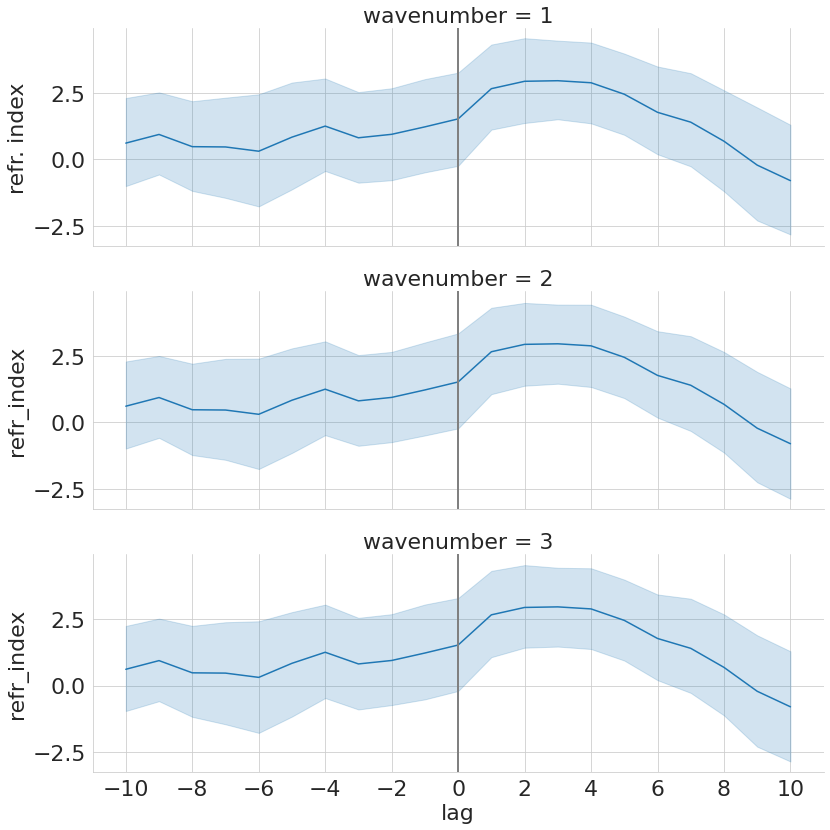

In [14]:
sel_what = 'himalayas'
threshold_dict = dict(aspect_ratio = 2.3, 
                      centroid_latitude = 72,
                      uref_ratio = 0.4,
                      kurtosis = 1.7,
                      objective_area = None)
                      
mask = (df_all['what'] == sel_what)# & (df_all['wavenumber'] == 1) 
data = df_all[mask]#.drop(columns = '')

g = sns.FacetGrid(data,  sharey=True,  height = 4, aspect = 3, row = 'wavenumber')#, margin_titles = True) row = 'wavenumber',
g.map(sns.lineplot, "lag", sel_var, n_boot=10000)
g.map(plt.axvline, x=0, c='gray', lw = 2)
#g.set(yscale='log')
#g.map(plt.axhline, y=0, c='k')
g.axes[0][0].xaxis.set_major_locator(MultipleLocator(2))
g.axes[0][0].set_ylabel('refr. index')
g.axes[0][0].set_xlabel('lag [day]')
#plt.savefig(f'refr_lagA_composite_CI.pdf', bbox_inches='tight')

In [ ]:
ds_ri_clim = xr.open_dataarray(f'{root_path}refr_index/refr_index_climatology_woSSW.nc')
ds_ri_clim['plev'] = ds_ri_clim.plev/100.

In [ ]:
levels = np.logspace(1, 3, num = 21)
levels[0] = 0.
levels

In [ ]:
p  = ds_ri_clim.sel(month = [11,12,1,2,3], \
               wavenumber = 1, \
               plev = slice(300,10), 
               lat = slice(0,None)).plot(col = 'month', levels = levels, yincrease = False, \
                                         cmap = 'viridis', extend = 'neither', size = 5)

plt.yscale('log')

for ax in p.axes.flatten():
    ax.axvline(35, color = 'k')
    ax.axvline(45, color = 'k')
    ax.axhline(70, color = 'k')
    ax.axhline(200, color = 'k')

In [ ]:
ds_ri_clim.sel(month = [12,1,2], \
               wavenumber = 1, \
               plev = 70, 
               lat = slice(0,None)).plot.line(col = 'month', size = 5)

In [ ]:
p  = ds_ri_clim.sel(month = [11,12,1,2,3], \
               wavenumber = 1, \
               plev = slice(300,10), 
               lat = slice(0,None)).plot.contourf(col = 'month', robust = True, yincrease = False, \
                                         cmap = 'viridis', extend = 'neither', size = 5)

plt.yscale('log')

for ax in p.axes.flatten():
    ax.axvline(35, color = 'k')
    ax.axvline(45, color = 'k')
    ax.axhline(70, color = 'k')
    ax.axhline(200, color = 'k')